In [1]:
import os
import psutil

import pandas as pd
from comet_ml import Experiment, ExistingExperiment
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import einops
import mne
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset as TDataset, DataLoader

from datasets import DatasetDict, Dataset
from datasets import load_dataset, load_metric

# from lion_pytorch import Lion

# from transformers import Wav2Vec2CTCTokenizer
# from transformers import Wav2Vec2FeatureExtractor
# from transformers import Wav2Vec2Processor
# from transformers import Wav2Vec2Model

# from envelope_detector.envelope_detector import EnvelopeDetector, create_importance_indices, create_spatial_patterns, create_temporal_patterns

import scipy.special

import datetime
import time

/opt/conda/envs/meta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_factor(l, m):
    result = math.log(2 * l + 1)
    result -= math.log((2 if m==0 else 1) * 2 * math.pi)
    result += scipy.special.gammaln(l - abs(m) + 1)
    result -= scipy.special.gammaln(l + abs(m) + 1)
    result /= 2
    result = math.exp(result)
    return result

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# torch.set_default_tensor_type('torch.cuda.DoubleTensor')
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 68.57 GB out of 125.69 GB


In [5]:
class CLIPloss(nn.Module):
    def __init__(
        self,
        clip_temperature,
        clip_temperature_type,
    ):
        super().__init__()
        if clip_temperature_type == 'param':
            self.temperature = nn.Parameter(torch.tensor(math.log(clip_temperature), dtype=torch.float32))
        elif clip_temperature_type == 'hparam':
            self.temperature = torch.tensor(math.log(clip_temperature), dtype=torch.float32, requires_grad=False)

    def forward(self, brainwave_embeddings, audio_embeddings):
        batch_size = brainwave_embeddings.size(0)
        if len(audio_embeddings.shape) == 3:
            brainwave_embeddings = F.normalize(brainwave_embeddings, dim=(-2, -1))
            audio_embeddings = F.normalize(audio_embeddings, dim=(-2, -1))
            similarity = torch.einsum('Bef, bef -> Bb', brainwave_embeddings, audio_embeddings)
        elif len(audio_embeddings.shape) == 2:
            brainwave_embeddings = F.normalize(brainwave_embeddings, dim=(-1))
            audio_embeddings = F.normalize(audio_embeddings, dim=(-1))
            similarity = torch.einsum('Bf, bf -> Bb', brainwave_embeddings, audio_embeddings)
        similarity_temperature = similarity / torch.exp(self.temperature)
        labels = torch.arange(batch_size).to(similarity.device)
        loss = F.cross_entropy(similarity, labels)
        loss_temperature = F.cross_entropy(similarity_temperature, labels)
        return loss, loss_temperature

In [6]:
class MSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, brainwave_embeddings, audio_embeddings, temperature):
        brainwave_embeddings = einops.rearrange(brainwave_embeddings, 'b f t -> b (f t)')
        audio_embeddings = einops.rearrange(audio_embeddings, 'b f t -> b (f t)')
        loss = self.mse(brainwave_embeddings, audio_embeddings)
        return loss

In [7]:
def metrics(brainwave_embeddings, audio_embeddings, labels):
    if len(audio_embeddings.shape) == 3:
        brainwave_embeddings = F.normalize(brainwave_embeddings, dim=(-2, -1))
        audio_embeddings = F.normalize(audio_embeddings, dim=(-2, -1))
        similarity = torch.einsum('Bef, bef -> Bb', brainwave_embeddings, audio_embeddings)
    elif len(audio_embeddings.shape) == 2:
        brainwave_embeddings = F.normalize(brainwave_embeddings, dim=(--1))
        audio_embeddings = F.normalize(audio_embeddings, dim=(-1))
        similarity = torch.einsum('Bf, bf -> Bb', brainwave_embeddings, audio_embeddings)
    labels = labels.view(-1,1)
    
    index_top10 = torch.topk(similarity, 10, dim=-1).indices
    index_top1 = torch.topk(similarity, 1, dim=-1).indices
    is_in_top10 = torch.eq(index_top10, labels).any(dim=1)
    is_in_top1 = torch.eq(index_top1, labels).any(dim=1)
    return is_in_top10, is_in_top1

In [8]:
class SpatialAttentionLayer(nn.Module):
    def __init__(self, n_input, n_output, K, coords_xy, n_dropout, dropout_radius, seed=None):
        super().__init__()

        self.n_input = n_input
        self.n_dropout = n_dropout
        self.dropout_radius = dropout_radius
        
        coords_xy = torch.tensor(coords_xy, dtype=torch.float32, requires_grad=False)
        self.register_buffer('_coords_xy', coords_xy)
        
        fourier_layout = self._create_fourier_layout(n_input, K, coords_xy)
        self.register_buffer('_fourier_layout', fourier_layout)
        
        Z = self._create_parameters(n_input, n_output, K, seed)
        self.Z = nn.Parameter(Z)

        
    def _create_fourier_layout(self, n_input, K, coords_xy):
        coords_x = coords_xy[:,0]
        coords_y = coords_xy[:,1]
        fourier_layout = torch.zeros((2, K, K, n_input), requires_grad=False)
        for k in range(K):
            for l in range(K):
                coords = 2 * math.pi * ((k+1) * coords_x + (l+1) * coords_y)
                fourier_layout[0,k,l,:] = torch.cos(coords)
                fourier_layout[1,k,l,:] = torch.sin(coords)
        fourier_layout = einops.rearrange(fourier_layout, 'a k l i -> 1 a k l i')
        return fourier_layout

    def _create_parameters(self, n_input, n_output, K, seed=None):
        if seed is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
        generator = torch.Generator()
        generator.manual_seed(seed)
        
        Z = torch.randn(size=((n_output, 2, K, K)), generator=generator) * 2 / (n_input + n_output)
        Z = einops.rearrange(Z, 'j a k l -> j a k l 1')
        return Z
    
    def to(self, device):
        self._coords_xy = self._coords_xy.to(device)
        self._fourier_layout = self._fourier_layout.to(device)
        return super().to(device)

    def get_spatial_filter(self):
        A = einops.reduce(self.Z * self._fourier_layout, 'j a k l i -> j i', 'sum')
        ASoftmax = F.softmax(A, dim=1)
        return ASoftmax.clone().detach()
    
    def forward(self, x):
        A = einops.reduce(self.Z * self._fourier_layout, 'j a k l i -> j i', 'sum')
        if self.training and self.n_dropout > 0:
            mask = torch.zeros((1, self.n_input), dtype=A.dtype, device=A.device)
            dropout_location = torch.rand(size=(self.n_dropout, 2), device=A.device) * 0.8 + 0.1
            for k in range(self.n_dropout):
                for i in range(self.n_input):
                    if torch.linalg.norm(self._coords_xy[i] - dropout_location[k]) <= self.dropout_radius:
                        mask[:,i] = - float('inf')
            A = A + mask
        ASoftmax = F.softmax(A, dim=1)
        SAx = torch.einsum('oi, bit -> bot', ASoftmax, x)
        return SAx

In [9]:
class SubjectPlusLayer(nn.Module):
    def __init__(self, n_input, n_output, n_subjects, regularize=True, bias=False, seed=None):
        super().__init__()
        self.bias = bias
        self.regularize = regularize
        if self.regularize:
            self.regularizer = None
        
        A, b = self._create_parameters(n_input, n_output, n_subjects)
        self.A = nn.Parameter(A)

        I = torch.zeros((1, n_output, n_input), requires_grad=False)
        self.register_buffer('I', I)
        
        if self.bias:
            self.b = nn.Parameter(b)
            zero = torch.zeros(size=(1, n_output, 1))
            self.register_buffer('zero', zero)
        
    def _create_parameters(self, n_input, n_output, n_subjects, seed=None):
        A = torch.zeros(size=(n_subjects, n_output, n_input))
        b = torch.zeros(size=(n_subjects, n_output, 1)) if self.bias else None
        with torch.no_grad():
            for subjects in range(n_subjects):
                layer = nn.Conv1d(in_channels=n_input, out_channels=n_output, kernel_size=1)
                A[subjects] = einops.rearrange(layer.weight.data, 'o i 1 -> o i')
                if self.bias:
                    b[subjects] = einops.rearrange(layer.bias.data, 'o -> o 1')
        return A, b
    
    def _create_regularizer(self, A, b):
        batch_size = A.shape[0]
        reg = torch.norm(A - self.I, p='fro')
        if self.bias:
            reg += torch.norm(b, p='fro')
        reg = reg / batch_size
        return reg
    
    def get_regularizer(self):
        regularizer = self.regularizer
        self.regularizer = None
        return regularizer
    
    def forward(self, x, s):
        batch_size = x.shape[0]
        
        A = torch.cat([self.I, self.A], dim=0)
        s[s >= A.size(0)] = 0
        A_ = A[s,:,:]
        out = torch.einsum('bji, bit -> bjt', A_, x)
        
        if self.bias:
            b = torch.cat([self.zero, self.b], dim=0)
            b_ = b[s,:,:]
            out = out + b_
        
        if self.regularize and self.training:
            self.regularizer = self._create_regularizer(A_, b_)
            
        return out


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, n_input, n_output, block_index):
        super().__init__()
        
        self.kernel_size = 3
        self.block_index = block_index
        dilation1 = 2**(2*block_index % 5)
        dilation2 = 2**((2*block_index + 1) % 5)
        dilation3 = 2
        
        self.conv1 = nn.Conv1d(in_channels=n_input, out_channels=n_output, kernel_size=self.kernel_size, dilation=dilation1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=n_output, out_channels=n_output, kernel_size=self.kernel_size, dilation=dilation2, padding='same')
        self.conv3 = nn.Conv1d(in_channels=n_output, out_channels=2*n_output, kernel_size=self.kernel_size, dilation=dilation3, padding='same')
        
        self.batchnorm1 = nn.BatchNorm1d(n_output)
        self.batchnorm2 = nn.BatchNorm1d(n_output)
        
        self.activation1 = nn.GELU()
        self.activation2 = nn.GELU()
        self.activation3 = nn.GLU(dim=-2)

    def forward(self, x):
        
        c1x = self.conv1(x)
        res1 = c1x if self.block_index == 0 else x + c1x
        res1 = self.batchnorm1(res1)
        res1 = self.activation1(res1)
        
        c2x = self.conv2(res1)
        res2 = res1 + c2x
        res2 = self.batchnorm2(res2)
        res2 = self.activation2(res2)
        
        c3x = self.conv3(res2)
        out = self.activation3(c3x)

        return out

In [11]:
class ConvHead(nn.Module):
    def __init__(self, n_channels, n_features, pool, head_stride):
        super().__init__()
        
        
        if pool == 'max':
            self.pool = nn.Sequential(
                nn.MaxPool1d(kernel_size=3, stride=stride, padding=0 if head_stride==2 else 1),
                nn.Conv1d(in_channels=n_channels, out_channels=2*n_channels, kernel_size=1)
            )
        elif pool == 'conv':
            self.pool = nn.Conv1d(in_channels=n_channels, out_channels=2*n_channels, kernel_size=3, stride=head_stride, padding=0 if head_stride==2 else 1)
            
        self.conv = nn.Conv1d(in_channels=2*n_channels, out_channels=n_features, kernel_size=1)
        self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm1d(n_features)

    def forward(self, x):
        x = self.pool(x)
        x = self.activation(x)
        x = self.conv(x)
        x = self.batch_norm(x)
        return x

In [12]:
class SpatialModule(nn.Module):
    def __init__(
        self,
        n_input,
        n_attantion,
        n_unmix,
        use_spatial_attention,
        n_spatial_harmonics,
        coords_xy_scaled,
        spatial_dropout_number,
        spatial_dropout_radius,
        use_unmixing_layer,
        use_subject_layer,
        n_subjects,
        regularize_subject_layer,
        bias_subject_layer,
    ):
        super().__init__()
        
        if use_spatial_attention:
            self.self_attention = SpatialAttentionLayer(
                n_input, n_attantion, n_spatial_harmonics, coords_xy_scaled, spatial_dropout_number, spatial_dropout_radius
            )
        else: self.self_attention = None

        if use_unmixing_layer:
            n_attantion = n_attantion if self.self_attention else n_input
            self.unmixing_layer = nn.Conv1d(in_channels=n_attantion, out_channels=n_attantion, kernel_size=1)
        else: self.unmixing_layer = None
            
        if use_subject_layer:
            n_attantion = n_attantion if (self.self_attention or self.unmixing_layer) else n_input
            self.subject_layer = SubjectPlusLayer(
                n_attantion, n_unmix, n_subjects, regularize=regularize_subject_layer, bias=bias_subject_layer
            )
        else: self.subject_layer = None

    def forward(self, xs):
        x, s = xs
        x = self.self_attention(x) if self.self_attention else x
        x = self.unmixing_layer(x) if self.unmixing_layer else x
        x = self.subject_layer(x, s) if self.subject_layer else x
        return x

In [13]:
class TemporalModule(nn.Module):
    def __init__(
        self,
        n_unmix,
        n_block,
    ):
        super().__init__()

        self.conv_blocks = nn.ModuleDict()
        for block_index in range(0, 5):
            n_in = n_unmix if block_index == 0 else n_block
            self.conv_blocks[f'conv_block_{block_index}'] = ConvBlock(n_in, n_block, block_index)

    def forward(self, x):
        for _, module in self.conv_blocks.items():
            x = module(x)
        return x

In [14]:
class BrainModule(nn.Module):
    def __init__(
        self,
        **kwargs
    ):
        super().__init__()
        self.spatial_module = SpatialModule(
            n_input=kwargs["n_channels_input"],
            n_attantion=kwargs["n_channels_attantion"],
            n_unmix=kwargs["n_channels_unmix"],
            use_spatial_attention=kwargs["use_spatial_attention"],
            n_spatial_harmonics=kwargs["n_spatial_harmonics"],
            coords_xy_scaled=np.load(kwargs["dirprocess"] + 'coords/coords208_xy_scaled.npy'),
            spatial_dropout_number=kwargs["spatial_dropout_number"],
            spatial_dropout_radius=kwargs["spatial_dropout_radius"],
            use_unmixing_layer=kwargs["use_unmixing_layer"],
            use_subject_layer=kwargs["use_subject_layer"],
            n_subjects=kwargs["n_subjects"],
            regularize_subject_layer=kwargs["regularize_subject_layer"],
            bias_subject_layer=kwargs["bias_subject_layer"],
        )
        
        self.temporal_module = TemporalModule(
            n_unmix=kwargs["n_channels_unmix"],
            n_block=kwargs["n_channels_block"],
        )

        self.feature_projection = ConvHead(
            kwargs["n_channels_block"], 
            kwargs["n_features"], 
            kwargs["head_pool"],
            kwargs["head_stride"],
        )


    def forward(self, xs):
        z = self.spatial_module(xs)
        y = self.temporal_module(z)
        y = self.feature_projection(y)
        return z, y

In [15]:
class DoubleDataset(TDataset):
    def __init__(self, meg, hidden, df, meg_sr, meg_offset=0):

        self.meg = meg
        self.hidden = hidden
        self.df = df
        self.meg_sr = meg_sr
        self.meg_offset = int(meg_offset * self.meg_sr)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        row_df = self.df.loc[index]
        
        subject_id, session_id, story_id = row_df['subject_id'], row_df['session_id'], row_df['story_id']
        sbj = torch.tensor(subject_id, dtype=torch.long)
        subject_id = str(subject_id)
        subject_id = '0' + subject_id if len(subject_id) == 1 else subject_id
        subset = f'subject{subject_id}_session{session_id}_story{story_id}'
        
        meg_start, meg_stop = row_df[f'meg{self.meg_sr}_start'], row_df[f'meg{self.meg_sr}_stop']
        meg_start, meg_stop = meg_start + self.meg_offset, meg_stop + self.meg_offset
        wav_index = row_df['wav_index']
        
        meg = torch.tensor(self.meg[subset][:,meg_start:meg_stop], dtype=torch.float32)
        hid = torch.tensor(self.hidden[wav_index], dtype=torch.float32)
        widx = torch.tensor(wav_index, dtype=torch.long)

        return meg, sbj, hid, widx

In [16]:
class Trainer:
    def __init__(self, model, hparam, experiment=None):
        self.model = model
        self.experiment = experiment
        if hparam["loss"] == "clip": self.criterion = CLIPloss(
            clip_temperature=hparam["clip_temperature"], clip_temperature_type=hparam["clip_temperature_type"]
        )
        elif hparam["loss"] == "mse": self.criterion = MSE()
        
        parameters = [
            {'params': self.model.spatial_module.parameters(), 'lr':hparam["lr_fe"], 'weight_decay':hparam["weight_decay"]},
            {'params': self.model.temporal_module.parameters(), 'lr':hparam["lr_fe"], 'weight_decay':hparam["weight_decay"]},
            {'params': self.model.feature_projection.parameters(), 'lr':hparam["lr_fe"], 'weight_decay':hparam["weight_decay"]},
            {'params': self.criterion.parameters(), 'lr':hparam["clip_temperature_lr"], 'weight_decay':0}
        ]
            
        if hparam["optim"] == "Adam": self.optimizer = torch.optim.Adam(parameters)
        elif hparam["optim"] == "AdamW": self.optimizer = torch.optim.AdamW(parameters)
        
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=hparam["scheduler_rate"]) if hparam["use_scheduler"] else None
        self.save_file = hparam["checkpoint"]

    
    def fit(self, dataloader_train, dataloader_val, hidden_test, nepoch=1, device_index=0):
        hidden_test = torch.tensor(hidden_test, dtype=torch.float32).to(f'cuda:{device_index}')
        hidden_test = einops.rearrange(hidden_test, 'b t f -> b f t')
        torch.cuda.empty_cache()

        self.model = self.model.to(f'cuda:{device_index}')
        self.criterion = self.criterion.to(f'cuda:{device_index}')
        val_loss_min = float('inf')
        
        for epoch in range(nepoch):
            
            self.model.train()
            self.criterion.train()
            train_loss = 0
            pbar = tqdm(dataloader_train, leave=False)
            for meg, sbj, hidden, _ in pbar:
                pbar.set_description(desc=f"train epoch {epoch}")
  
                hidden = einops.rearrange(hidden, 'b t f -> b f t')
                meg, sbj, hidden = meg.to(f'cuda:{device_index}'), sbj.to(f'cuda:{device_index}'), hidden.to(f'cuda:{device_index}')
                _, result = self.model((meg, sbj))

                _, loss_temperature = self.criterion(result, hidden)
                
                self.optimizer.zero_grad()
                loss_temperature.backward()
                self.optimizer.step()
                train_loss += loss_temperature.detach().cpu().numpy().item() * meg.shape[0]
                
            train_loss /= len(dataset_train)
            if self.experiment is not None:
                self.experiment.log_metric("loss_train", train_loss, step=epoch)
                
            self.optimizer.zero_grad()
            if self.scheduler:
                self.scheduler.step()
            
            
            # now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            # checkpoint_filename = f"checkpoint_{now}_epoch_{epoch}.pth"
            # checkpoint_filepath = 'model_checkpoints/' + checkpoint_filename
            # Save checkpoint
            # checkpoint = {
            #     "epoch": epoch,
            #     "model_state_dict": self.model.module.state_dict(),
            #     "optimizer_state_dict": self.optimizer.state_dict(),
            # }
            # torch.save(checkpoint, checkpoint_filepath)
            del meg, sbj, hidden, loss_temperature, result
            torch.cuda.empty_cache()
            
            time.sleep(1)
            model.eval()
            self.criterion.eval()
            val_loss = 0
            pbar = tqdm(dataloader_val, leave=False)
            is_in_top10s, is_in_top1s = [], []
            for meg, sbj, hidden, widx in pbar:
                with torch.no_grad():
                    pbar.set_description(desc=f"val epoch {epoch}")
                    hidden = einops.rearrange(hidden, 'b t f -> b f t')
                        
                    meg, sbj, hidden, widx = meg.to(f'cuda:{device_index}'), sbj.to(f'cuda:{device_index}'), hidden.to(f'cuda:{device_index}'), widx.to(f'cuda:{device_index}')
                    _, result = model((meg, sbj))
    
                    _, loss_temperature = self.criterion(result, hidden)
                    val_loss += loss_temperature.detach().cpu().numpy().item() * meg.shape[0]
    
                    is_in_top10, is_in_top1 = metrics(result, hidden_test, widx)
                    is_in_top10s.append(is_in_top10.detach().cpu().numpy())
                    is_in_top1s.append(is_in_top1.detach().cpu().numpy())
                
            top10s = np.mean(np.concatenate(is_in_top10s)).item()
            top1s = np.mean(np.concatenate(is_in_top1s)).item()
            
            val_loss /= len(dataset_test)
            if self.experiment is not None:
                self.experiment.log_metric("loss_test", val_loss, step=epoch)
                self.experiment.log_metric("top10s_test", top10s, step=epoch)
                self.experiment.log_metric("top1s_test", top1s, step=epoch)

            if val_loss < val_loss_min:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': val_loss,
                }, f"checkpoint/{self.save_file}.pt")
                val_loss = val_loss_min
            
            del meg, sbj, hidden, loss_temperature, result
            torch.cuda.empty_cache()

In [17]:
# name: "SimpleNet", "BrainModule"
# pool = 'max', 'conv'
# optim = 'Adam', 'AdamW'
# loss = 'clip', 'mse'
# hidden = 'hidden_state_last4avg', 'hidden_state_last', 'extract_features', 'lms'
# preprocess = 'default', 'filter02hp', 'filter4hp', 'filter12hp',  'filter12lp', 'filter30lp'
# conv_type = 'conv', 'att'
# preprocess = 'default', 'rearranged'

hyper_params = {
    "name": "BrainModule",
    "batch_size": 100,
    "lr_fe":3e-4,
    "use_scheduler":False,
    "scheduler_rate":0.95,
    "optim":"AdamW",
    "weight_decay":1e-1,
    "clip_temperature":1,
    "clip_temperature_type":"param",
    "clip_temperature_lr":1e-1,
    "meg_sr":100,
    "meg_offset":0.15,
    "hidden":"extract_features",
    "n_subjects":27,
    "preprocess":"default",

    "n_channels_input":208,
    "n_channels_attantion":270,
    "n_channels_unmix":270,
    "use_spatial_attention":True,
    "n_spatial_harmonics":32,
    "spatial_dropout_number":0, 
    "spatial_dropout_radius":0.1,
    "use_unmixing_layer":True,
    "use_subject_layer":True,
    "regularize_subject_layer":False,
    "bias_subject_layer":False,
    "n_channels_block":320,
    "n_blocks":5,
    "head_pool":"conv",
    "n_features":1024,
    "loss":"clip",
    "head_stride":2,
    
}

if hyper_params["hidden"] == "extract_features":
    hyper_params["n_features"] = 512
if hyper_params["hidden"] == 'lms':
    hyper_params["n_features"] = 120
    hyper_params["head_stride"] = 1

dirprocess = '/mnt/datasets/MASC-MEG/process_v2/'
hyper_params["dirprocess"] = dirprocess
coords_xy_scaled = np.load(dirprocess + 'coords/coords208_xy_scaled.npy')
hyper_params["robust_scale"] = 1
hyper_params["checkpoint"] = 'baseline270'
# hyper_params["coords_xy_scaled"] = coords_xy_scaled

In [18]:
# n_subjects = hyper_params["n_subjects"]

# dirprocess = 'datasets/MASC-MEG/process_v1/'

# coords_xy_scaled = np.load(dirprocess + 'coords/coords208_xy_scaled.npy')
# hyper_params["coords_xy_scaled"] = coords_xy_scaled

hidden_train = np.load(dirprocess + f'audio/{hyper_params["hidden"]}_train4.npy')
hidden_test = np.load(dirprocess + f'audio/{hyper_params["hidden"]}_test4.npy')

df_train = pd.read_csv(dirprocess + f'dataframe/df_train{hyper_params["n_subjects"]}.csv')
df_test = pd.read_csv(dirprocess + f'dataframe/df_test{hyper_params["n_subjects"]}.csv')

meg = dict(np.load(dirprocess + f'meg/meg{hyper_params["n_subjects"]}_sr{hyper_params["meg_sr"]}_{hyper_params["preprocess"]}_v{hyper_params["robust_scale"]}.npz'))

In [19]:
# hyper_params["coords_xy_scaled"] = coords_xy_scaled

In [20]:
dataset_train = DoubleDataset(meg, hidden_train, df_train, hyper_params["meg_sr"], hyper_params["meg_offset"])
dataset_test = DoubleDataset(meg, hidden_test, df_test, hyper_params["meg_sr"], hyper_params["meg_offset"])

In [21]:
dataloader_train = DataLoader(dataset_train, batch_size=hyper_params['batch_size'], shuffle=True, drop_last=True)#, generator=torch.Generator(device='cuda'))
dataloader_test = DataLoader(dataset_test, batch_size=hyper_params['batch_size'] // 5, shuffle=False)#, generator=torch.Generator(device='cuda'))

In [32]:
meg_, sjt, hid, w = next(iter(dataloader_train))

In [33]:
experiment = Experiment(
    api_key="h1D6l9T1S26xlDYKakWxGBudo",
    project_name=f'metameg{hyper_params["n_subjects"]}',
    workspace="amvosk",
    auto_output_logging=False,
)

experiment.log_parameters(hyper_params)
experiment.log_code()
# experiment = None

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/mnt/Active_projects/amvosk/MetaMEG' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/amvosk/metameg27/4ddd0001f59e423d8f67cbde0916605e

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring


In [34]:
model = BrainModule(**hyper_params)

In [35]:
trainer = Trainer(model, hyper_params, experiment=experiment)

In [36]:
# Z, fourier_layout = trainer.model.spatial_module.self_attention.Z, trainer.model.spatial_module.self_attention._fourier_layout

In [37]:
# A = einops.reduce(Z * fourier_layout, 'j a k l i -> j i', 'sum')

In [38]:
# ASoftmax = F.softmax(A, dim=1)

In [39]:
# ASoftmax_numpy = ASoftmax.detach().cpu().numpy()

In [40]:
# U, S, Vt = np.linalg.svd(ASoftmax_numpy)

In [41]:
# Vt[0]

In [42]:
try:
    trainer.fit(dataloader_train, dataloader_test, hidden_test, nepoch=10, device_index=2)
finally:
    if trainer.experiment:
        experiment.end()
    trainer.experiment = None

val epoch 2:  61%|██████▏   | 1502/2448 [01:49<01:06, 14.13it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
model = BrainModule(**hyper_params)

In [23]:
checkpoint = torch.load(f'checkpoint/{hyper_params["checkpoint"]}.pt')

model = model.to('cpu')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval();

In [24]:
attention_matrix = model.spatial_module.self_attention.get_spatial_filter().numpy()

In [25]:
attention_sum = attention_matrix.sum(axis=0)

In [26]:
from pathlib import Path
import mne_bids

dirpath = '/mnt/datasets/MASC-MEG/bids_anonym/'
bids_root = Path(dirpath)

subject, session, task = 1, 0, 0
subject_index = "0" + str(subject) if len(str(subject)) == 1 else str(subject)
bids_path = mne_bids.BIDSPath(
    subject=subject_index,
    session=str(session),
    task=str(task),
    datatype="meg",
    root=bids_root,
)

try:
    raw = mne_bids.read_raw_bids(bids_path, verbose=False)
except FileNotFoundError:
    print("missing", subject, session, task)

raw = raw.pick_types(
    meg=True, misc=False, eeg=False, eog=False, ecg=False
)

layout = mne.channels.find_layout(raw.info)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_168453/3457455693.py:18: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


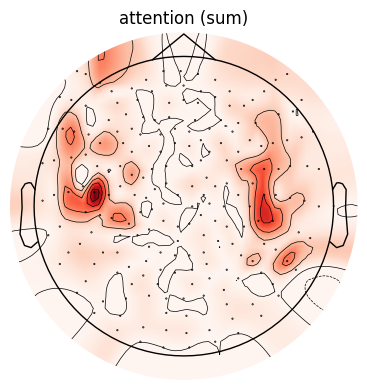

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = np.asarray([[ax]])

mne.viz.plot_topomap(attention_sum, (layout.pos -0.5)*2, show=False, axes=ax[0,0], sphere=1)
ax[0,0].set_title(f'attention (sum)')

fig.tight_layout()
fig.savefig(f'image2/attention (sum)')
plt.show()

In [ ]:
U, S, Vh = np.linalg.svd(attention_matrix)
attention_svd = Vh[0]

In [ ]:
plt.plot(S)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
# ax = np.asarray([[ax]])

for j in range(3):
    for i in range(2):
        mne.viz.plot_topomap(Vh[i*3+j], (layout.pos -0.5)*2, show=False, axes=ax[i,j], sphere=1)
        ax[i,j].set_title(f'attention (svd), {i*3+j}')

fig.tight_layout()
fig.savefig(f'image2/attention (svd)')
plt.show()

In [40]:
10 + 9 + 7 + 5 + 7.55

38.55